# Inverse Kinematics on Stretch

This tutorial looks at doing inverse kinematics on Stretch. It'll use the [IKPy](https://github.com/Phylliade/ikpy) and [Stretch Body](https://github.com/hello-robot/stretch_body) to solve for and execute end effector goals on the robot.

**Prerequisites**:
 - A Stretch RE1 or Stretch 2 robot
 - Either the Standard gripper or Dex Wrist attached to the robot
 - Beginner level familiarity with Python and Linear Algebra

**How to run**
 1. Power on and connect to Stretch (keyboard/mouse/HDMI or via SSH)
 2. Navigate to the directory this notebook lives in and run `jupyter notebook --no-browser`
 3. If SSH-ed, open a tunnel for Jupyter using `ssh -L 8888:localhost:8888 <ip addr>`
 4. Click on Jupyter's link (e.g. looks like `http://localhost:8888/?token=<some token>`)
 5. Shift + Enter to execute the cells below

### Creating the chain

With our new cartesian URDF of Stretch, let's create an IKPy chain.

In [1]:
import rospkg
import os
import ikpy.urdf.utils
import numpy as np
from IPython import display
import ipywidgets as widgets
import ikpy.chain

In [2]:
rospack = rospkg.RosPack()
# the urdf is generated in my macbook using the original jupyter notebook
iktuturdf_path: str = os.path.join(
    rospack.get_path("driver_assistance"), "urdf", "stretch_iktut.urdf"
)
chain = ikpy.chain.Chain.from_urdf_file(iktuturdf_path)
chain


/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_mast is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_arm_l4 is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_gripper is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus 

Kinematic chain name=chain links=['Base link', 'joint_base_translation', 'joint_mast', 'joint_lift', 'joint_arm_l4', 'joint_arm_l3', 'joint_arm_l2', 'joint_arm_l1', 'joint_arm_l0', 'joint_wrist_yaw', 'joint_gripper', 'joint_grasp_center'] active_links=[ True  True  True  True  True  True  True  True  True  True  True  True]

IKPy gives us an overview of the chain at `chain.links`.

In [9]:
# chain.links


### Current robot configuration

We'll need to be able to read the current configuration the robot is in. Let's define `get_current_configuration(tool)` to do this.

In [10]:
# TODO
# def get_current_configuration(tool):
#     def bound_range(name, value):
#         names = [l.name for l in chain.links]
#         index = names.index(name)
#         bounds = chain.links[index].bounds
#         return min(max(value, bounds[0]), bounds[1])

#     if tool == 'tool_stretch_gripper':
#         q_base = 0.0
#         q_lift = bound_range('joint_lift', robot.lift.status['pos'])
#         q_arml = bound_range('joint_arm_l0', robot.arm.status['pos'] / 4.0)
#         q_yaw = bound_range('joint_wrist_yaw', robot.end_of_arm.status['wrist_yaw']['pos'])
#         return [0.0, q_base, 0.0, q_lift, 0.0, q_arml, q_arml, q_arml, q_arml, q_yaw, 0.0, 0.0]
#     elif tool == 'tool_stretch_dex_wrist':
#         q_base = 0.0
#         q_lift = bound_range('joint_lift', robot.lift.status['pos'])
#         q_arml = bound_range('joint_arm_l0', robot.arm.status['pos'] / 4.0)
#         q_yaw = bound_range('joint_wrist_yaw', robot.end_of_arm.status['wrist_yaw']['pos'])
#         q_pitch = bound_range('joint_wrist_pitch', robot.end_of_arm.status['wrist_pitch']['pos'])
#         q_roll = bound_range('joint_wrist_roll', robot.end_of_arm.status['wrist_roll']['pos'])
#         return [0.0, q_base, 0.0, q_lift, 0.0, q_arml, q_arml, q_arml, q_arml, q_yaw, 0.0, q_pitch, q_roll, 0.0, 0.0]


The stow configuration should look like [0.0, 0.0, 0.0, ~0.2, 0.0, 0.0, 0.0, 0.0, 0.0, ~3.4, optional pitch and roll joints, 0.0, 0.0]

### Solving IK for a goal point

IKPy fixes the world frame at the robot's `base_link`, so all goals are are defined with respect to the base link. We'll start by asking IKPy to calculate a configuration for the robot that achieves a target 3D point, without any orientation constraints.

In [3]:
target_point = [-0.043, -0.441, 0.654]


`inverse_kinematics()` performs the pseudo-inverse IK method. Be sure to pass it the robot's current configuration as the initial position, or the optimization might not converge.

In [4]:
q_init = [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    8.98041255162881e-07,
    8.98041255162881e-07,
    8.98041255162881e-07,
    8.98041255162881e-07,
    0.0,
    0.0,
    0.0,
]
q_soln = chain.inverse_kinematics(target_point, initial_position=q_init)
with np.printoptions(precision=3, suppress=True):
    print(f"solution is {q_soln}")
    print(
        f"error is {np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_point)}"
    )


solution is [ 0.    -0.032  5.783  0.628 -4.282  0.023  0.023  0.023  0.023  0.05
  0.     0.   ]
error is 5.5718709703670725e-14


Passing the IK solution through FK allows us to compute the difference between our target pose and where the solution would place the end-effector.

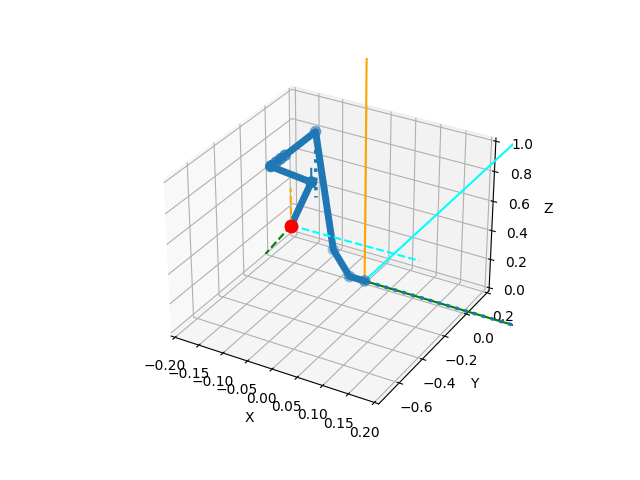

In [5]:
%matplotlib widget
import ikpy.utils.plot as plot_utils
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q_soln, ax, target=target_point)

### Solving IK for a goal pose

Now we know how to use IKPy to solve for a configuration that gets us to a target 3D point. However, notice in the previous plot how IKPy's solution is unnecessarily complicated. It has the robot extending its arm out and reaching back with the yaw joint to get to the target point. A simpler solution would be to retract the arm in and extend the yaw outwards to achieve the same point. In this section, we'll add an orientation constraint to the target point, thereby making it a target 3D pose. The orientation constraint will give a solution that has the gripper pointing away from the robot.

In [6]:
target_point = [-0.043, -0.441, 0.654]
target_orientation = ikpy.utils.geometry.rpy_matrix(0.0, 0.0, -np.pi / 2)
pretarget_orientation = ikpy.utils.geometry.rpy_matrix(0.0, 0.0, 0.0)


IKPy often has trouble with the revolute joints at the end of the arm, so we use a trick here to target an orientation that's easier to converge to (i.e. pretarget orientation), and use the pretarget solution to jump start the optimization to the real target orientation. In this example, we're providing a constraint for all three rotational axes, so `orientation_mode` must be set to "all". It's also possible to constraint just one axis. See [the docs](https://ikpy.readthedocs.io/en/latest/inverse_kinematics.html) for more details.

In [7]:
q_mid = chain.inverse_kinematics(
    target_point, pretarget_orientation, orientation_mode="all", initial_position=q_init
)
q_soln = chain.inverse_kinematics(
    target_point, target_orientation, orientation_mode="all", initial_position=q_mid
)
with np.printoptions(precision=3, suppress=True):
    print(f"solution is {q_soln}")
    print(
        f"error is {np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_point)}"
    )


solution is [   0.      -0.022  -43.165    0.628 -153.624    0.023    0.023    0.023
    0.023    0.       0.       0.   ]
error is 3.966966312415157e-15


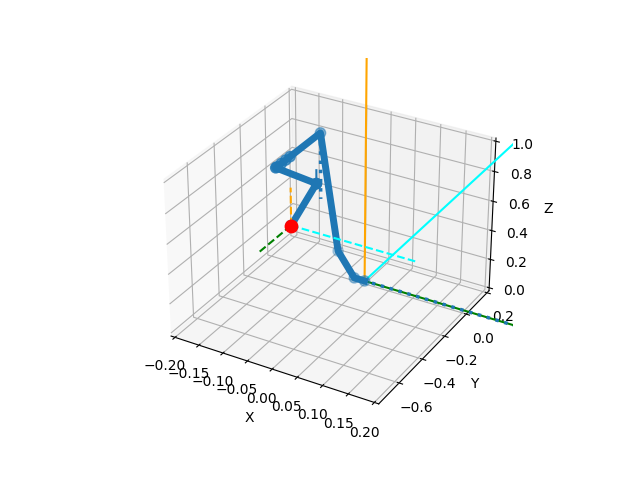

In [8]:
%matplotlib widget
import ikpy.utils.plot as plot_utils
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q_soln, ax, target=target_point)

### Move robot to configuration

We can now use Stretch Body to execute the configuration IKPy solved for in order to get to our target point. Let's define `move_to_configuration(tool, q)` to do this.

In [17]:
# TODO
# def move_to_configuration(tool, q):
#     if tool == 'tool_stretch_gripper':
#         q_base = q[1]
#         q_lift = q[3]
#         q_arm = q[5] + q[6] + q[7] + q[8]
#         q_yaw = q[9]
#         robot.base.translate_by(q_base)
#         robot.lift.move_to(q_lift)
#         robot.arm.move_to(q_arm)
#         robot.end_of_arm.move_to('wrist_yaw', q_yaw)
#         robot.push_command()
#     elif tool == 'tool_stretch_dex_wrist':
#         q_base = q[1]
#         q_lift = q[3]
#         q_arm = q[5] + q[6] + q[7] + q[8]
#         q_yaw = q[9]
#         q_pitch = q[11]
#         q_roll = q[12]
#         robot.base.translate_by(q_base)
#         robot.lift.move_to(q_lift)
#         robot.arm.move_to(q_arm)
#         robot.end_of_arm.move_to('wrist_yaw', q_yaw)
#         robot.end_of_arm.move_to('wrist_pitch', q_pitch)
#         robot.end_of_arm.move_to('wrist_roll', q_roll)
#         robot.push_command()


The robot should move to its stow configuration first, and then move to the gripper out configuration we previously solved for.

### Tying it together

Finally, we can wrap IKPy's calculations and `move_to_configuration()` to solve and execute to a target goal. Let's define `move_to_grasp_goal(target_pose)` to do this.

In [18]:
# TODO
# def move_to_grasp_goal(target_pose, pretarget_pose=None, plot_prompt=False):
#     q_init = get_current_configuration(tool=robot.end_of_arm.name)
#     if pretarget_pose is not None:
#         q_init = chain.inverse_kinematics_frame(pretarget_pose, orientation_mode='all', initial_position=q_init)
#     q_soln = chain.inverse_kinematics_frame(target_pose, orientation_mode='all', initial_position=q_init)
#     if plot_prompt:
#         fig, ax = plot_utils.init_3d_figure()
#         plt.xlim(-0.2, 0.2)
#         plt.ylim(-0.75, 0.2)
#         ax.set_zlim(0.0, 1.0)
#         chain.plot(q_soln, ax, target=target_pose[:3, 3])
#         plot_utils.show_figure()

#         button = widgets.Button(description="Execute move")
#         output = widgets.Output()
#         display.display(button, output)
#         def on_button_clicked(b):
#             with output:
#                 err = np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_pose[:3, 3])
#                 if not np.isclose(err, 0.0, atol=1e-2):
#                     print("IKPy did not find a valid solution")
#                     return
#                 move_to_configuration(tool=robot.end_of_arm.name, q=q_soln)
#                 return q_soln
#         button.on_click(on_button_clicked)
#     else:
#         err = np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_pose[:3, 3])
#         if not np.isclose(err, 0.0, atol=1e-2):
#             print("IKPy did not find a valid solution")
#             return
#         move_to_configuration(tool=robot.end_of_arm.name, q=q_soln)
#         return q_soln


In [19]:
# goal = np.array([[-0.23815889, -0.97049054, -0.03779491, -0.07488198],
#        [ 0.97087237, -0.23894213,  0.01770604,  0.05378699],
#        [-0.02621434, -0.03247718,  0.99912864,  0.2738502 ],
#        [ 0.        ,  0.        ,  0.        ,  1.        ]])
# move_to_grasp_goal(goal, plot_prompt=True)


In [9]:
import rospkg
import os
import ikpy.urdf.utils
import numpy as np
from IPython import display
import ipywidgets as widgets
import ikpy.chain

rospack = rospkg.RosPack()
# the urdf is generated in my macbook using the original jupyter notebook
iktuturdf_path: str = os.path.join(
    rospack.get_path("driver_assistance"), "urdf", "stretch_iktut.urdf"
)
active_mask = [False, True, False, True, False, True, True, True, True, True, False, False]
chain = ikpy.chain.Chain.from_urdf_file(iktuturdf_path, active_links_mask=active_mask)
chain


/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_mast is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_arm_l4 is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/robo/envs/shared_auto/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_gripper is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus 

Kinematic chain name=chain links=['Base link', 'joint_base_translation', 'joint_mast', 'joint_lift', 'joint_arm_l4', 'joint_arm_l3', 'joint_arm_l2', 'joint_arm_l1', 'joint_arm_l0', 'joint_wrist_yaw', 'joint_gripper', 'joint_grasp_center'] active_links=[False  True False  True False  True  True  True  True  True False False]

In [10]:
from __future__ import annotations
import rospy
from sensor_msgs.msg import JointState


class joint_state_listener:
    def __init__(self) -> None:
        rospy.init_node("joint_state_listener", anonymous=True)
        rospy.Subscriber("/joint_states", JointState, self.joint_state_cb)

    def joint_state_cb(self, joint_states: JointState) -> None:
        self.msg: JointState = joint_states

    # publish rate is 50Hz in gazebo
    def get_latest_pos(self) -> tuple[rospy.Duration, tuple]:
        duration: rospy.Duration = rospy.get_rostime() - self.msg.header.stamp
        # name: - joint_arm_l0 - joint_arm_l1 - joint_arm_l2 - joint_arm_l3 - joint_gripper_finger_left
        #   - joint_gripper_finger_right - joint_head_pan - joint_head_tilt - joint_left_wheel
        #   - joint_lift - joint_right_wheel - joint_wrist_yaw
        q_modified = (
            0.0,
            0.0,
            0.0,
            self.msg.position[self.msg.name.index("joint_lift")],
            0.0,
            self.msg.position[self.msg.name.index("joint_arm_l3")],
            self.msg.position[self.msg.name.index("joint_arm_l2")],
            self.msg.position[self.msg.name.index("joint_arm_l1")],
            self.msg.position[self.msg.name.index("joint_arm_l0")],
            self.msg.position[self.msg.name.index("joint_wrist_yaw")],
            0.0,
            0.0,
        )
        return duration, q_modified


JointStateListener = joint_state_listener()


0.01 (0.0, 0.0, 0.0, 0.1989995166931084, 0.0, -3.0816105928620455e-07, -3.404851593054914e-07, -3.436594211855845e-07, -2.0522101785777013e-08, 3.138999289140236, 0.0, 0.0)


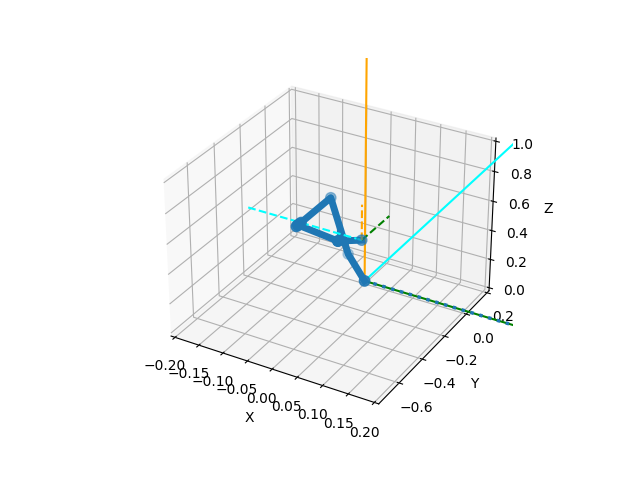

In [11]:
%matplotlib widget
import ikpy.utils.plot as plot_utils
import matplotlib.pyplot as plt
dur, q = JointStateListener.get_latest_pos()
print(dur.to_sec(), q)
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q, ax)

In [22]:
q_init_fallback = [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    8.98041255162881e-07,
    8.98041255162881e-07,
    8.98041255162881e-07,
    8.98041255162881e-07,
    0.0,
    0.0,
    0.0,
]

target_point = [-0.043, -0.441, 0.654]
dur, q_init = JointStateListener.get_latest_pos()
print(q_init)
if q_init[5] < 0: q_init = q_init_fallback
q_soln = chain.inverse_kinematics(target_point, initial_position=q_init)
with np.printoptions(precision=3, suppress=True):
    print(f"solution is {q_soln}")
    print(f"error is {np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_point)}")

(0.0, 0.0, 0.0, 0.31899900210433346, 0.0, 0.059999731070781014, 0.059999373255738696, 0.05999932115306904, 0.059999922972973845, 3.1389994953798355, 0.0, 0.0)
solution is [ 0.    -0.074  0.     0.628  0.     0.124  0.124  0.124  0.124  2.886
  0.     0.   ]
error is 1.1007774713630669e-08


0.009 (0.0, 0.0, 0.0, 0.31899900366555617, 0.0, 0.05999974714914722, 0.05999937600447938, 0.05999932257642569, 0.05999992794484066, 3.138999509297913, 0.0, 0.0)


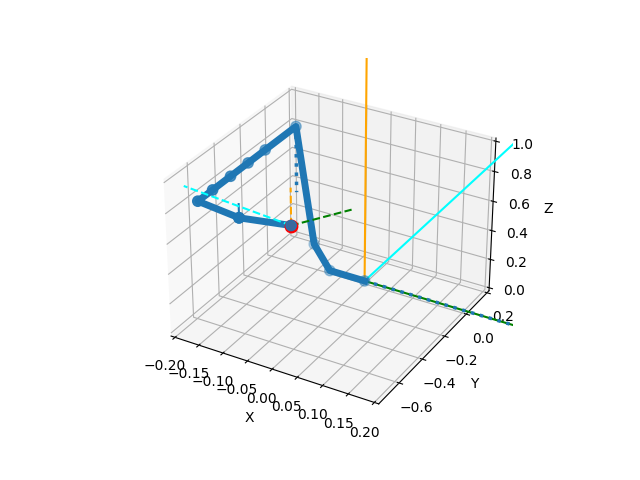

In [23]:
%matplotlib widget
import ikpy.utils.plot as plot_utils
import matplotlib.pyplot as plt
dur, q = JointStateListener.get_latest_pos()
print(dur.to_sec(), q)
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q_soln, ax, target=target_point)